# Titanic: Machine Learning from disaster

In this project I will go over some of the techniques I used to predict whether passengers lived or died on the tianic.

I have created a lot of feature engineering functions for family and title that may be of use to anyone interested in this Kaggle competition

For anyone starting out with the titanic competition I would recommend these tutorials as a good starting point. 

http://ahmedbesbes.com/how-to-score-08134-in-titanic-kaggle-challenge.html

http://trevorstephens.com/kaggle-titanic-tutorial/getting-started-with-r/ (This tutorial uses R but the principles are all easily translated to pandas)


In this tutorial I use both random forest and XGBoost (both using cross validation to tune parameters) to predict whether someone survived. 

My highest score to date using these methods is 0.79904 using a random forest classifier, currently in the top 16%. Not the best of scores, but this has been a great entry into machine learning for me. In particular this notebook demonstrates a lot of the different methods you can use when data cleansing and feature engineering. This might also be useful for anyone who wants to learn how to use grid search and xgboost.





In [128]:
#import pandas, numpy and display
import pandas as pd
import numpy as np
from IPython.display import display, HTML

In [129]:
#Open training data
%matplotlib inline
dfTrain= pd.read_csv('C:/Users/jcarp/programming/data_science/train.csv')

In [77]:
#Display first five observations
display(dfTrain.head())

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Pclass: This denotes the class of passenger, with 3 being the cheapest fare class and 1 being the most expensive fare class

SibSp: This denotes whether the passenger is travelling with either a sibling or spouse

Parch: Is used to denote whether the passenger is a parent with child or a child with parent

Embarked: Denotes where the passenger boarded the titanic from Southampton,Queenstown or Cherbourg

In [78]:
#import matplot for graphs

import matplotlib.pyplot as plt

Age  Fare   Sex
                 mean  mean count
Sex    Survived                  
female 0         25.0  23.0    81
       1         28.8  51.9   233
male   0         31.6  22.0   468
       1         27.3  40.8   109

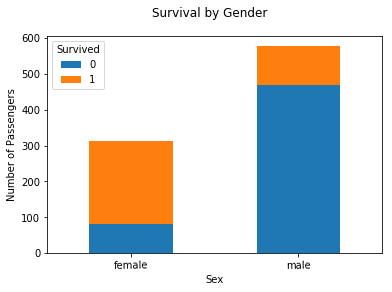

In [79]:
#Summary statistics of the sample train data by gender 
f = {'Age':['mean'],'Fare':['mean'],'Sex':['count']}
dfSummary = dfTrain.groupby(['Sex','Survived']).agg(f).round(1)
display(dfSummary)

#Create stacked bar chart
bChart = dfTrain.groupby(['Sex','Survived'])['Sex'].count().unstack().plot(kind='bar', stacked=True,rot=1)
plt.suptitle("Survival by Gender")
plt.ylabel("Number of Passengers")

Survived,0,1,Survival Rate
Pclass,,,
1,80,136,0.63
2,97,87,0.47
3,372,119,0.24


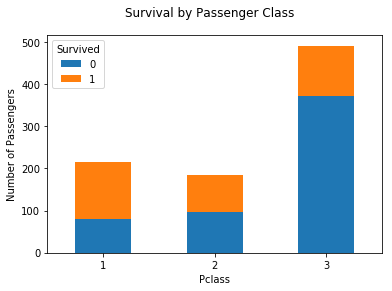

In [80]:
#Summary statistics of the sample train data by class
classSummary = dfTrain.groupby(['Pclass','Survived'])['Survived'].count().unstack()
classSummary['Survival Rate'] = (classSummary[1] / (classSummary[0] + classSummary[1])).round(2)
display(classSummary)

classSummary.drop(['Survival Rate'],axis=1,inplace=True)
classSummary.plot(kind='bar',stacked=True,rot=1)
plt.suptitle("Survival by Passenger Class")
plt.ylabel("Number of Passengers")

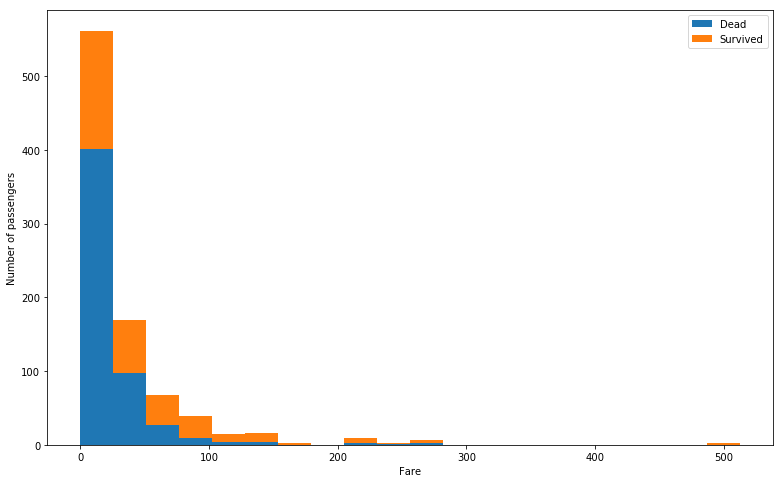

In [81]:
#Summary statistics of survival rate by fare

figure = plt.figure(figsize=(13,8))
plt.hist([dfTrain[dfTrain['Survived']==0]['Fare'],dfTrain[dfTrain['Survived']==1]['Fare']], stacked=True,
         bins = 20,label = ['Dead','Survived'])
plt.xlabel('Fare')
plt.ylabel('Number of passengers')
plt.legend()

## Data Cleansing

Having gone over several other online tutorials the best results are usually derived from combining both the train and test datasets into one in order to cleanse the data. When filling in missing data and feature engineering this leads to more accurate results.


In [49]:
train = pd.read_csv('C:/Users/jcarp/programming/data_science/train.csv')
test  = pd.read_csv('C:/Users/jcarp/programming/data_science/test.csv')

In [50]:
#combine data

train.drop('Survived',inplace=True,axis=1)
combine = train.append(test).reset_index()
combine.drop('index',inplace=True,axis=1)


In [57]:
combine.isnull().sum()

PassengerId       0
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

As we can see from the table above that the columns that have the most missing values are Age and Cabin. Embarked contains 2 missing values and Fare 1 so we can substitue the mean for these

In [58]:
#Cleanse sex column. Replace 'male' and 'female' with binary values 
def sexCleanse(df):
    #Replace Male/Female with 0/1
    df['Sex'] = np.where(df['Sex'] == 'male',0,1)
    return df

In [60]:
#Cleanse embarked column
def embarkCleanse(df):
    #Convert the embarked classes to integer form
    df['Embarked'].fillna('C',inplace=True)
    embarkDictionary = {
    "S": 0,
    "Q": 1,
    "C": 2}
    
    df['Embarked'] = df.Embarked.map(embarkDictionary)
    
    return df

In [61]:
#Cleanse the fare and categorise the values
def fareCleanse(df):
    df.loc[ df['Fare'] <= 7.91, 'Fare'] = 0
    df.loc[(df['Fare'] > 7.91) & (df['Fare'] <= 14.454), 'Fare'] = 1
    df.loc[(df['Fare'] > 14.454) & (df['Fare'] <= 31), 'Fare']   = 2
    df.loc[ df['Fare'] > 31, 'Fare']= 3
    df['Fare'] = df['Fare'].astype(int)
    
    return df

In [62]:
#Fill in the missing fare values
def fareFill(df):
    df['AvgFare'] = df.groupby(['Sex','Pclass','Title'])['Fare'].transform('mean')
    df['Fare'].fillna(df['AvgFare'],inplace=True)
    df.drop('AvgFare',inplace=True,axis=1)
    
    return df

In [63]:
#Cleanse age and categorise values
def ageCleanse(df):
    df.loc[ df['Age'] <= 16, 'Age'] = 0
    df.loc[(df['Age'] > 16) & (df['Age'] <= 32), 'Age'] = 1
    df.loc[(df['Age'] > 32) & (df['Age'] <= 48), 'Age']   = 2
    df.loc[(df['Age'] > 48) & (df['Age'] <= 64), 'Age']   = 3
    df.loc[ df['Age'] > 64, 'Age']= 4
    df['Age'] = df['Age'].astype(int)
    
    return df

In [64]:
#Fill in the missing age values
def ageFill(df):
    df['TitleAge'] = df.groupby(['Sex','Pclass','Title'])['Age'].transform('median').round(1)
    df['Age'].fillna(df['TitleAge'],inplace=True)
    
    return df


In [67]:
#Create a title column from name. 
def titleCleanse(df):
    #Create a new column title
    df['Title'] = df['Name'].str.split(',', 2).str[1].str.split('.', 1).str[0].str.strip()
    Title_Dictionary = {
    "Capt":       "Officer",
    "Col":        "Officer",
    "Major":      "Officer",
    "Jonkheer":   "Sir",
    "Don":        "Sir",
    "Sir" :       "Sir",
    "Dr":         "Mr",
    "Rev":        "Mr",
    "the Countess":"Lady",
    "Dona":       "Lady",
    "Mme":        "Mrs",
    "Mlle":       "Miss",
    "Ms":         "Mrs",
    "Mr" :        "Mr",
    "Mrs" :       "Mrs",
    "Miss" :      "Miss",
    "Master" :    "Master",
    "Lady" :      "Lady"}
    
    df['Title'] = df.Title.map(Title_Dictionary)
    
    df['NameLen'] = df['Name'].str.len()
    
    return df

In [68]:
# Create a surname column from name
def surnameCleanse(df):
    df['Surname'] = df['Name'].str.split(',').str[0]
    
    return df

In [70]:
# cleanse cabin and create a new column 'deck'
def cabinCleanse(df):
    #Convert cabin to numeric based off first character of column 
    df['Room']  = df['Cabin'].copy()
    df['Room'] = df['Room'].str[1:4]
    df['Room'] = df['Room'].convert_objects(convert_numeric=True)
    df['Room'].fillna(0,inplace=True)
    df['Deck'] = df['Cabin'].astype(str).str[0]
    
    deckDictionary = {
        "n": 0,
        "A": 1,
        "B": 2,
        "C": 3,
        "D": 4,
        "E": 5,
        "F": 6,
        "G": 7,
        "T": 8
    }

    df['Deck'] = df.Deck.map(deckDictionary)
    
    
    return df 

In [71]:
#Create various family column 
def createFamily(df):
    df['Mother'] = np.where((df['Age'] > 18) & (df['Sex'] == 1) & (df['Parch'] > 0),1,0)
    df['FamilyCount'] = df['SibSp'] + df['Parch'] + 1
    
    df['FamilyCount'].replace(to_replace=np.nan, value=0, inplace=True)
    
    familyBins = [0,1,4,20]
    familyLabels = ['single', 'small','large']
     
    df['FamilySize'] = pd.cut(df['FamilyCount'],familyBins,labels=familyLabels)
    
    df['FamilyId'] = np.where((df['FamilyCount'] > 2), df['Surname'] + df['FamilyCount'].astype(str), 'None')
    
    return df

In [72]:
def ticketCleanse(df):
    ticket = df['Ticket']
    ticket = ticket.replace('.','')
    ticket = ticket.replace('/','')
    
        
    df['Ticket1'] = np.where((df['Ticket'].str.contains(' ')) ,(df['Ticket'].str.split(' ',1).str[0].str.strip()),'xxxx')
    df['Ticket1'] =df['Ticket1'].str.replace('/','')
    df['Ticket1'] =df['Ticket1'].str.replace('.','')
    df['Ticket1'] = df['Ticket1'].str[:3].str.strip()
    #df['Ticket2'] = df['Ticket'].str.split(' ',1).str.strip()
    
    df['TicketLen'] = df['Ticket'].str.len()
    
    df.drop('Ticket1',inplace=True,axis=1)
    
    
    return df
        
        

In [73]:
def binVariables(df):
    ageBins = [0,15,30,60,100]
    ageLabels = ['Child','yAdult','mAdult','oAdult'];
    df['AgeBin'] = pd.cut(df['Age'],ageBins,labels=ageLabels)
    
    fareBins = [0,10,20,30,40,50,100,500]
    fareLabels = ['0-10','10-20','20-30','30-40','40-50','50-100','100-500'];
    df['FareBin'] = pd.cut(df['Fare'],fareBins,labels=fareLabels)
    
    age_dummies = pd.get_dummies(df['AgeBin'],prefix='Age')
    df = pd.concat([df,age_dummies],axis=1)
                   
    fare_dummies = pd.get_dummies(df['FareBin'],prefix='Fare')
    df = pd.concat([df,fare_dummies],axis=1)
    
    df.drop(['FareBin','AgeBin'],inplace=True,axis=1)
    
    
    return df

In [82]:
def dummifyVariables(df):
    titles_dummies = pd.get_dummies(df['Title'],prefix='Title')
    df = pd.concat([ df, titles_dummies], axis=1)
    
    fsize_dummies = pd.get_dummies(df['FamilySize'],prefix='FS')
    df = pd.concat([df,fsize_dummies],axis=1)
    
    pclass_dummies = pd.get_dummies(df['Pclass'],prefix='Pclass')
    df = pd.concat([df,pclass_dummies],axis=1)       
    
    deck_dummies = pd.get_dummies(df['Deck'],prefix='Deck')
    df = pd.concat([df,deck_dummies],axis=1)
    
    #ticket_dummies = pd.get_dummies(df['Ticket1'],prefix='Ticket')
    #df = pd.concat([df,ticket_dummies],axis=1)
    
    familyId_dummies = pd.get_dummies(df['FamilyId'],prefix='FamId')
    df = pd.concat([df,familyId_dummies],axis=1)
    
    return df
    

In [83]:
#Run the functions defined above to cleanse the data 
#cleanse data 
combine = sexCleanse(combine)
combine = embarkCleanse(combine)
combine = titleCleanse(combine)
combine = surnameCleanse(combine)

combine = cabinCleanse(combine)
combine = createFamily(combine)
combine = ticketCleanse(combine)


#fill in missing values 
combine = ageFill(combine)
combine = fareFill(combine)

#convert age and fare to categorical
combine = ageCleanse(combine)
combine = fareCleanse(combine)

#bin variables
#combine = binVariables(combine)

#dummify variables
combine = dummifyVariables(combine)


combine.drop(['Ticket','FamilyId','Surname','Deck','Pclass','FamilySize','Name','Title','TitleAge','Room','Cabin','Embarked'],inplace=True,axis=1)

display(combine)

C:\Users\jcarp\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


,PassengerId,Sex,Age,SibSp,Parch,Fare,NameLen,Mother,FamilyCount,TicketLen,...,FamId_Thomas3,FamId_Touma3,FamId_Van Impe3,FamId_Vander Planke3,FamId_Vander Planke4,FamId_Wells3,FamId_West4,FamId_Wick3,FamId_Widener3,FamId_van Billiard3
0,1,0,1,1,0,0,23,0,2,9,...,0,0,0,0,0,0,0,0,0,0
1,2,1,2,1,0,3,51,0,2,8,...,0,0,0,0,0,0,0,0,0,0
2,3,1,1,0,0,1,22,0,1,16,...,0,0,0,0,0,0,0,0,0,0
3,4,1,2,1,0,3,44,0,2,6,...,0,0,0,0,0,0,0,0,0,0
4,5,0,2,0,0,1,24,0,1,6,...,0,0,0,0,0,0,0,0,0,0
5,6,0,1,0,0,1,16,0,1,6,...,0,0,0,0,0,0,0,0,0,0
6,7,0,3,0,0,3,23,0,1,5,...,0,0,0,0,0,0,0,0,0,0
7,8,0,0,3,1,2,30,0,5,6,...,0,0,0,0,0,0,0,0,0,0
8,9,1,1,0,2,1,49,1,3,6,...,0,0,0,0,0,0,0,0,0,0
9,10,1,0,1,0,2,35,0,2,6,...,0,0,0,0,0,0,0,0,0,0


In [85]:
#scale features
#This is used to normalize all values so that they are all between 0 and 1. 
def scaleFeatures(df):
    
    features = list(df.columns)
    features.remove('PassengerId')
    df[features] = df[features].apply(lambda x: x/x.max(), axis=0)
    
    return df

combine = scaleFeatures(combine)
display(combine)

,PassengerId,Sex,Age,SibSp,Parch,Fare,NameLen,Mother,FamilyCount,TicketLen,...,FamId_Thomas3,FamId_Touma3,FamId_Van Impe3,FamId_Vander Planke3,FamId_Vander Planke4,FamId_Wells3,FamId_West4,FamId_Wick3,FamId_Widener3,FamId_van Billiard3
0,1,0.0,0.25,0.125,0.000000,0.000000,0.280488,0.0,0.181818,0.500000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,1.0,0.50,0.125,0.000000,1.000000,0.621951,0.0,0.181818,0.444444,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,1.0,0.25,0.000,0.000000,0.333333,0.268293,0.0,0.090909,0.888889,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,1.0,0.50,0.125,0.000000,1.000000,0.536585,0.0,0.181818,0.333333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,0.0,0.50,0.000,0.000000,0.333333,0.292683,0.0,0.090909,0.333333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,6,0.0,0.25,0.000,0.000000,0.333333,0.195122,0.0,0.090909,0.333333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,7,0.0,0.75,0.000,0.000000,1.000000,0.280488,0.0,0.090909,0.277778,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,8,0.0,0.00,0.375,0.111111,0.666667,0.365854,0.0,0.454545,0.333333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,9,1.0,0.25,0.000,0.222222,0.333333,0.597561,1.0,0.272727,0.333333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,10,1.0,0.00,0.125,0.000000,0.666667,0.426829,0.0,0.181818,0.333333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now that we have cleansed the data and created new columns we need to now split the data back out into training and test datasets

In [86]:
####Split combine into train and test
train = pd.DataFrame()
test = pd.DataFrame()
#define target
dfTrain= pd.read_csv('C:/Users/jcarp/programming/data_science/train.csv')
target =dfTrain["Survived"]

if combine.shape[0] > 891: # len(df) > 10 would also work
    train = combine[:891]
    test = combine[891:]

In [126]:
#calculate feature importances in order to trim down the size of the dataset being passed to the random forest. 
#This is used to avoid overfitting
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
clf = ExtraTreesClassifier(n_estimators=200)
clf = clf.fit(train, target)

In [127]:

features = pd.DataFrame()
features['feature'] = train.columns
features['importance'] = clf.feature_importances_
features.sort(['importance'],ascending=False)

C:\Users\jcarp\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,feature,importance
0,PassengerId,0.131922
6,NameLen,0.119665
13,Title_Mr,0.113257
1,Sex,0.097666
9,TicketLen,0.073559
5,Fare,0.049426
12,Title_Miss,0.043181
2,Age,0.043081
22,Pclass_3,0.043052
14,Title_Mrs,0.029673


In [107]:
# Recreate train dataset with top features
model = SelectFromModel(clf,prefit=True)
train_new = model.transform(train)
train_new.shape

(891, 21)

In [108]:
## Recreate test dataset with top features
model = SelectFromModel(clf,prefit=True)
test_new = model.transform(test)
test_new.shape

(418, 21)

## Random Forest Prediction

In [109]:
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.cross_validation import StratifiedKFold
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier
from sklearn.cross_validation import cross_val_score

In [103]:
#Here we are using cross_validation with several different values for max_depth and n_estimators. 
#This is used in order to determine the most accurate values for the random forest classifier

forest = RandomForestClassifier(n_jobs=-1)

parameter_grid = {
    'max_depth' : [4,5,6,7,8],
    'n_estimators': [200,210,240,250,260],
    'criterion': ['gini','entropy']

}

cross_validation = StratifiedKFold(target, n_folds=5)

grid_search = GridSearchCV(forest,
                          param_grid=parameter_grid,
                          cv=cross_validation)

grid_search.fit(train_new,target)

print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.8372615039281706
Best parameters: {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 210}


In [123]:
#Output the results of our predictions to a csv file ready for submission

output = grid_search.predict(test_new).astype(int)
df_output = pd.DataFrame()
df_output['PassengerId'] = dfTest['PassengerId']
df_output['Survived'] = output
df_output[['PassengerId','Survived']].to_csv('C:/Users/jcarp/programming/data_science/randomForest_solution.csv',index=False)

## XGBoost Prediction

In [116]:
import xgboost as xgb

In [120]:
#As with the RandomForest I am using cross validation to tune the settinngs of the XGBoost. 
#I have not included all the options of the parameter grid i have run overall as it would take too long to run
#This is something that you will need to play around with to get the parameters that are most effective
gbm = xgb.XGBClassifier(n_estimators=120,max_depth=3,min_child_weight=7,gamma=0.9,subsample=1.0,objective='binary:logistic',colsample_bytree=1,nthread=-1,scale_pos_weight=2)

parameter_grid = {
    'min_child_weight':[5,6,7,8,9,10,11,12],
    'max_depth':[1,2,3]
    
}


cross_validation = StratifiedKFold(target, n_folds=5)

grid_search = GridSearchCV(gbm,
                          param_grid=parameter_grid,
                          cv=cross_validation)

grid_search.fit(train_new,target)

print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.8372615039281706
Best parameters: {'max_depth': 2, 'min_child_weight': 8}


In [124]:
output = grid_search.predict(test_new).astype(int)
df_output = pd.DataFrame()
df_output['PassengerId'] = dfTest['PassengerId']
df_output['Survived'] = output
df_output[['PassengerId','Survived']].to_csv('C:/Users/jcarp/programming/data_science/xgb_solution.csv',index=False)